In [14]:
import tensorflow as tf

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation, Reshape, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt
import pickle


In [16]:
#unpacking the data saved using pickle
pickle_in = open("X_train.pickle","rb")
X_train_o = pickle.load(pickle_in)

pickle_in = open("y_train.pickle","rb")
y_train_o = pickle.load(pickle_in)


pickle_in = open("X_test.pickle","rb")
X_test_o = pickle.load(pickle_in)

pickle_in = open("y_test.pickle","rb")
y_test_o = pickle.load(pickle_in)


In [33]:
#categorising the y dataset and reshaping the x dataset

IMG_SIZE=32
y_train = to_categorical(y_train_o)
y_test = to_categorical(y_test_o)
X_train = np.array(X_train_o).reshape(-1, IMG_SIZE, IMG_SIZE,1)
X_test = np.array(X_test_o).reshape(-1, IMG_SIZE, IMG_SIZE,1)


print("The shape of x train data: {}".format(X_train.shape))
print("The shape of y train data: {}".format( y_train.shape))
print("The shape of x test data: {}".format( X_test.shape))
print("The shape of y test data: {}".format( y_test.shape))

The shape of x train data: (78200, 32, 32, 1)
The shape of y train data: (78200, 46)
The shape of x test data: (13800, 32, 32, 1)
The shape of y test data: (13800, 46)


(13800, 32, 32, 1)

In [18]:
#parameter for compiling the model
opt= Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
objective = 'categorical_crossentropy'

#parameter for the training (fit)
epoch = 40
batch_size = 64

# Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
#save the best model i.e. with lowest validation loss during the training
mc = ModelCheckpoint('best_model2.h5', monitor='val_loss', mode='min', verbose=1,save_best_only=True)


def NepNet():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding="same", input_shape=((32,32,1)))) #Convolutional layer-1
    model.add(BatchNormalization()) #Batch Normalistion
    model.add(Activation("relu"))#activation funtion
   
    model.add(Conv2D(128, (3, 3), padding="same")) #Convolutional layer-2
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))#max-pooling
  
    model.add(Conv2D(256, (3, 3), padding="same")) #Convolutional layer-3
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    model.add(Conv2D(512, (3, 3), padding="same"))#Convolutional layer-4
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))#max-pooling
    
    model.add(Conv2D(512, (1, 1), padding="same")) #Convolutional layer-5
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(Conv2D(46, (1, 1), padding="same"))#Convolutional layer-6
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(GlobalAveragePooling2D()) #Global Average Pooling
    
    model.add(Dense(46, activation='softmax')) 
    model.compile(loss=objective, optimizer=opt, metrics=['accuracy'])
    return model


In [27]:
model= NepNet()
def run_NepNet():
    
    history = LossHistory()
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epoch,
              validation_split=0.05, verbose=1, shuffle=True, callbacks=[history,mc])
    

    predictions = model.predict(X_test, verbose=0)
    return predictions, history

In [19]:
predictions, history = run_NepNet()

Epoch 1/40
1161/1161 [==============================] - ETA: 0s - loss: 0.9435 - accuracy: 0.8653
Epoch 00001: val_loss improved from inf to 0.22207, saving model to best_model2.h5
1161/1161 [==============================] - 25s 21ms/step - loss: 0.9435 - accuracy: 0.8653 - val_loss: 0.2221 - val_accuracy: 0.9601
Epoch 2/40
1160/1161 [============================>.] - ETA: 0s - loss: 0.0909 - accuracy: 0.9872
Epoch 00002: val_loss improved from 0.22207 to 0.16860, saving model to best_model2.h5
1161/1161 [==============================] - 25s 21ms/step - loss: 0.0909 - accuracy: 0.9872 - val_loss: 0.1686 - val_accuracy: 0.9532
Epoch 3/40
1160/1161 [============================>.] - ETA: 0s - loss: 0.0467 - accuracy: 0.9922
Epoch 00003: val_loss improved from 0.16860 to 0.09858, saving model to best_model2.h5
1161/1161 [==============================] - 25s 21ms/step - loss: 0.0467 - accuracy: 0.9922 - val_loss: 0.0986 - val_accuracy: 0.9765
Epoch 4/40
1161/1161 [======================

In [27]:
#checking the test accuracy of the moel after 40 epoch
def test_accuracy():
    err = []
    t = 0
    for i in range(predictions.shape[0]):
        if (np.argmax(predictions[i]) == y_test_o[i]):
            t = t+1
        else:
            err.append(i)
    return t, float(t)*100/predictions.shape[0], err, len(err)*100/predictions.shape[0]

result=test_accuracy()
print("Test accuracy: {} %".format(result[1]))
print("No. of mis-classification: {} ".format(len(result[2])))
print("Error rate: {} %".format(result[3]))

Test accuracy: 99.54347826086956 %
No. of mis-classification: 63 
Error rate: 0.45652173913043476 %


In [25]:
# checking the test accuracy of the best model i.e with lowest validation loss over the 40 epochs
savedmodel = load_model('best_model2.h5')
prediction_2 = savedmodel.predict(X_test, verbose=0)
def test_accuracy_2():
    err = []
    t = 0
    for i in range(prediction_2.shape[0]):
        if (np.argmax(prediction_2[i]) == y_test_o[i]):
            t = t+1
        else:
            err.append(i)
    return t, float(t)*100/prediction_2.shape[0], err, len(err)*100/predictions.shape[0]

t_acc=test_accuracy_2()
print("Test accuracy: {} %".format(t_acc[1]))
print("No. of mis-classification: {} ".format(len(t_acc[2])))
print("Error rate: {} %".format(t_acc[3]))


Test accuracy: 99.64492753623189 %
No. of mis-classification: 49 
Error rate: 0.35507246376811596 %


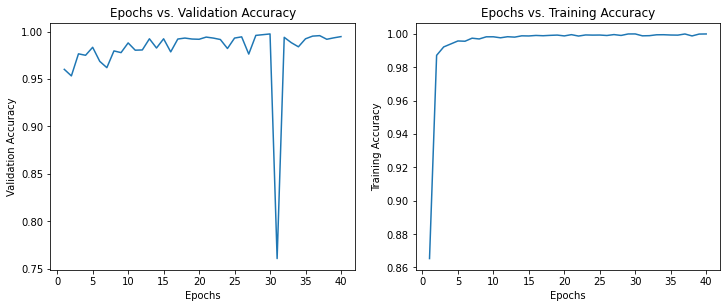

In [28]:
#plotting the validation and trainig accuracy against epoch
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,epoch+1), history.val_acc)
ax1.set(xlabel='Epochs', ylabel='Validation Accuracy',
       title='Epochs vs. Validation Accuracy')
ax2.plot(np.arange(1,epoch+1), history.acc)
ax2.set(xlabel='Epochs', ylabel='Training Accuracy',
       title='Epochs vs. Training Accuracy')
plt.show()

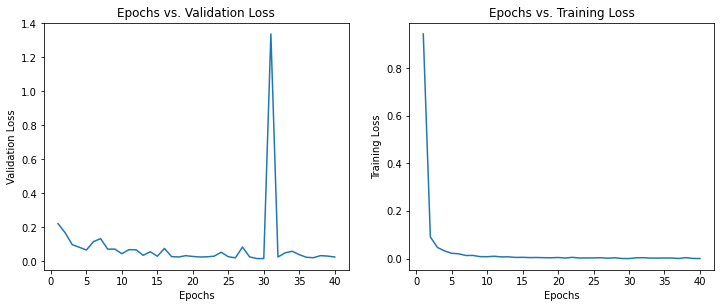

In [29]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,epoch+1), history.val_losses)
ax1.set(xlabel='Epochs', ylabel='Validation Loss',
       title='Epochs vs. Validation Loss')
ax2.plot(np.arange(1,epoch+1), history.losses)
ax2.set(xlabel='Epochs', ylabel='Training Loss',
       title='Epochs vs. Training Loss')
plt.show()

In [30]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 64)        640       
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_18 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
batch_normalization_19 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
activation_19 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 128)      